In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, ConvexHull, Delaunay
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

# Constants
hbar = 1.0
m = 1.0
a = 1.0     # FCC lattice constant
N = 50      # Grid resolution
sigma = 1.5 # Smoothing
num_bins = 200

# BCC reciprocal lattice vectors (reciprocal of FCC)
b1 = (2 * np.pi / a) * np.array([1, 1, 0])
b2 = (2 * np.pi / a) * np.array([1, 0, 1])
b3 = (2 * np.pi / a) * np.array([0, 1, 1])

# Generate reciprocal lattice points
n_range = range(-1, 2)
G = []
for n1 in n_range:
    for n2 in n_range:
        for n3 in n_range:
            G_vec = n1 * b1 + n2 * b2 + n3 * b3
            G.append(G_vec)
G = np.array(G)

In [14]:
# Voronoi to get Wigner-Seitz cell (first BZ)
vor = Voronoi(G)
origin_index = np.where(np.all(G == 0, axis=1))[0][0]
region_index = vor.point_region[origin_index]
region_vertices = vor.regions[region_index]
bz_vertices = np.array([vor.vertices[i] for i in region_vertices if i != -1])
bz_hull = ConvexHull(bz_vertices)

In [21]:
# Create k-grid cube
k_lin = np.linspace(-np.pi/a, np.pi/a, N)
kx, ky, kz = np.meshgrid(k_lin, k_lin, k_lin)
k_grid = np.stack([kx, ky, kz], axis=-1).reshape(-1, 3)

bz_delaunay = Delaunay(bz_vertices)

def in_bz(point):
    return bz_delaunay.find_simplex(point) >= 0

print("Filtering k-points inside BCC Brillouin zone...")
k_inside = [k for k in tqdm(k_grid) if in_bz(k)]
k_inside = np.array(k_inside)/np.pi

Filtering k-points inside BCC Brillouin zone...


100%|██████████| 125000/125000 [00:00<00:00, 236212.48it/s]


In [22]:
print(k_inside)

[[-1.         -1.         -1.        ]
 [-1.         -1.         -0.95918367]
 [-1.         -1.         -0.91836735]
 ...
 [ 1.          1.          0.91836735]
 [ 1.          1.          0.95918367]
 [ 1.          1.          1.        ]]


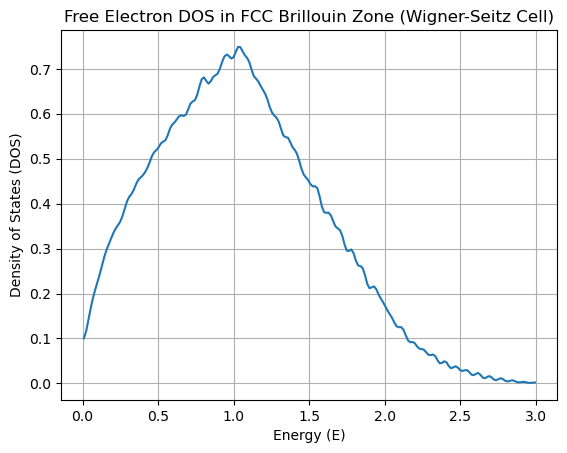

In [23]:
def E_free_e(k): 
    return np.linalg.norm(k)**2 
E = np.array([E_free_e(k) for k in k_inside])

# DOS histogram
dos, bins = np.histogram(E, bins=num_bins, density=True)
dos_smoothed = gaussian_filter1d(dos, sigma=sigma)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot
plt.plot(bin_centers, dos_smoothed)
plt.xlabel("Energy (E)")
plt.ylabel("Density of States (DOS)")
plt.title("Free Electron DOS in FCC Brillouin Zone (Wigner-Seitz Cell)")
plt.grid(True)
plt.show()